# Disease detection from Chest X-Ray

## Project Goal:

Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

📦 Dataset:

Chest X-Ray Images (Pneumonia) - Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia





- 5,863 total images across training, test, and validation folders



- Two classes: NORMAL, PNEUMONIA

In [3]:
import tensorflow as tf
import os

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/chest_xray"

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [7]:
train_gen = train_datagen.flow_from_directory(
    f"{data_dir}/train", target_size=(150,150), class_mode='binary', batch_size=32
)

Found 5244 images belonging to 2 classes.


In [8]:
test_gen = train_datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
)

Found 624 images belonging to 2 classes.


## Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

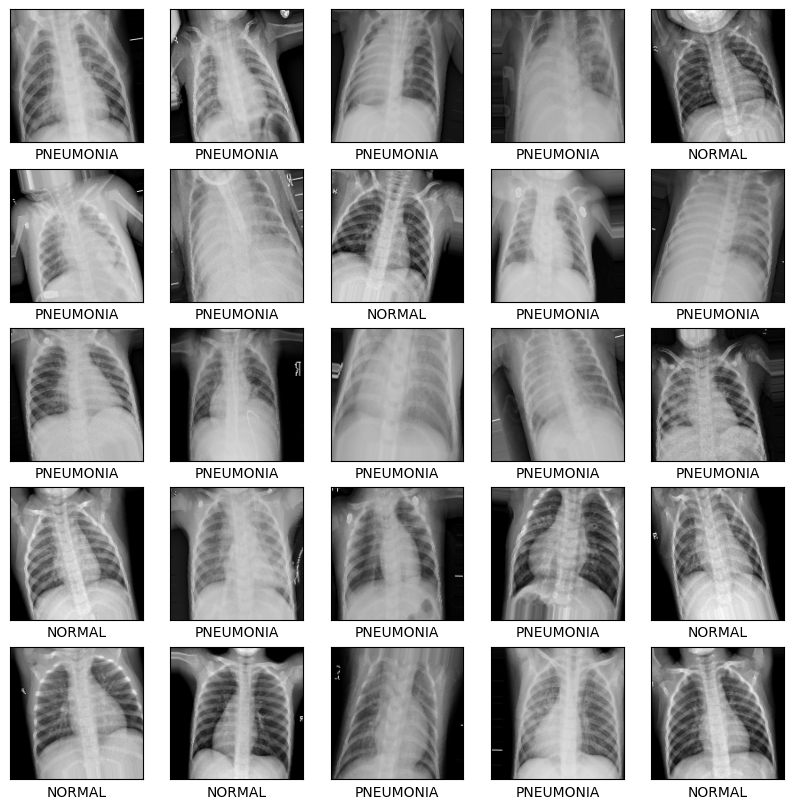

In [9]:

class_names = ['NORMAL', 'PNEUMONIA']

# Get 25 sample images from the training generator
images, labels = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    label = int(labels[i])
    plt.xlabel(class_names[label])
plt.show()


In [10]:
from collections import Counter
def count_classes(folder):
    normal = len(os.listdir(f"{folder}/NORMAL"))
    pneumonia = len(os.listdir(f"{folder}/PNEUMONIA"))
    return {'NORMAL': normal, 'PNEUMONIA': pneumonia}

print("Train:", count_classes(f"{data_dir}/train"))
print("Test:", count_classes(f"{data_dir}/test"))

Train: {'NORMAL': 1350, 'PNEUMONIA': 3896}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


There is a significant class imbalance, let's compute classs weights

In [11]:
from sklearn.utils import class_weight
import numpy as np
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

In [12]:
class_weights_dict = dict(enumerate(class_weights))
print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {0: np.float64(1.943661971830986), 1: np.float64(0.6731707317073171)}


In [14]:
unique, counts = np.unique(train_gen.classes, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("\n--- Original Class Counts ---")
for cls, count in class_distribution.items():
    print(f"{list(train_gen.class_indices.keys())[cls]}: {count}")


--- Original Class Counts ---
NORMAL: 1349
PNEUMONIA: 3895


In [15]:
# Weightedbalanced counts
balanced_counts = {cls: int(count * class_weights[i]) for i, (cls, count) in enumerate(class_distribution.items())}

print("\n--- Balanced Class Counts ---")
for cls, count in balanced_counts.items():
    print(f"{list(train_gen.class_indices.keys())[cls]}: {count}")


--- Balanced Class Counts ---
NORMAL: 2622
PNEUMONIA: 2622


## Create the convolutional base

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

##  Add Dense layers on top

In [20]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # Change output layer for binary classification

Here's the complete architecture of your model:

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,425 (18.28 MB)

 Trainable params: 4,791,425 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

## Compile & Train

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

history = model.fit(train_gen, validation_data=test_gen, epochs=10, class_weight=class_weights_dict)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1938s 12s/step - accuracy: 0.5860 - loss: 0.6882 - val_accuracy: 0.8189 - val_loss: 0.3823
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 94s 573ms/step - accuracy: 0.8802 - loss: 0.2933 - val_accuracy: 0.8413 - val_loss: 0.3759
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9146 - loss: 0.2209 - val_accuracy: 0.8446 - val_loss: 0.3763
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 94s 570ms/step - accuracy: 0.9082 - loss: 0.2252 - val_accuracy: 0.8606 - val_loss: 0.3442
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 93s 565ms/step - accuracy: 0.9216 - loss: 0.1953 - val_accuracy: 0.8590 - val_loss: 0.3856
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 93s 565ms/step - accuracy: 0.9306 - loss: 0.1856 - val_accuracy: 0.8189 - val_loss: 0.3988
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.9366 - loss: 0.1660 - val_accuracy: 0.8510 - val_loss: 0.3575
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 93s 566ms/step - accuracy: 0.9423 - loss: 0

The model shows strong learning on training data but struggles to generalize, as indicated by the rising validation loss and fluctuating validation accuracy. Overfitting is present and can be mitigated through data augmentation, dropout layers, or early stopping.

## Evaluation

Metrics + Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The model performs well at detecting PNEUMONIA (recall 83%, F1-score 0.71) but struggles with NORMAL cases (recall 14%, F1-score 0.19) due to class imbalance. Overall accuracy is 57%, indicating moderate performance. Improvements could include augmenting NORMAL images, tuning thresholds, or refining the model architecture to better capture minority class features.

Training Curves

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Interpretation & Conclusion

The model shows strong performance in detecting PNEUMONIA cases, with a recall of 83%, meaning it correctly identifies most pneumonia patients. However, its performance in recognizing NORMAL (healthy) cases is poor, with only 14% recall, indicating many healthy cases are misclassified. The overall accuracy of 57% reflects moderate predictive performance.

These results highlight that the model still needs improvement, particularly in better detecting normal cases and reducing false positives. Future work could focus on augmenting the minority class (NORMAL), refining the model architecture, or adjusting classification thresholds.